# **Data Cleaning**

## Objectives

* Handle missing values by filling them with appropriate replacements or removing irrelevant columns.
* Ensure all features have correct and consistent data types.
* Standardize numerical features to improve consistency and model performance.
* Apply a cleaning pipeline to make the cleaning process systematic and reproducible.
* Save the cleaned dataset for further analysis and modeling.

## Inputs

* outputs/datasets/collection/HousePricesRecords.csv: The raw collected data from the Data Collection step

## Outputs

* outputs/datasets/cleaned/HousePricesCleaned.csv: The cleaned data, ready for feature engineering and analysis

---

# Change working directory

* The notebooks are stored in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues'

## Load data

Load the data from the generated CSV file to inspect data types and preview the dataset structure.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from feature_engine.imputation import CategoricalImputer, MeanMedianImputer, ArbitraryNumberImputer
from feature_engine.selection import DropFeatures
from sklearn.pipeline import Pipeline

df = pd.read_csv("outputs/datasets/collection/HousePricesRecords.csv")
df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856.0,854.0,3.0,No,706.0,GLQ,150.0,0.0,548.0,RFn,...,65.0,196.0,61.0,5,7,856.0,0.0,2003,2003,208500.0
1,1262.0,0.0,3.0,Gd,978.0,ALQ,284.0,NaN,460.0,RFn,...,80.0,0.0,0.0,8,6,1262.0,NaN,1976,1976,181500.0
2,920.0,866.0,3.0,Mn,486.0,GLQ,434.0,0.0,608.0,RFn,...,68.0,162.0,42.0,5,7,920.0,NaN,2001,2002,223500.0
3,961.0,NaN,NaN,No,216.0,ALQ,540.0,NaN,642.0,Unf,...,60.0,0.0,35.0,5,7,756.0,NaN,1915,1970,140000.0
4,1145.0,NaN,4.0,Av,655.0,GLQ,490.0,0.0,836.0,RFn,...,84.0,350.0,84.0,5,8,1145.0,NaN,2000,2000,250000.0


##### **Visualize missing values** to easily identify which columns have missing data

In [2]:
# Evaluate the proportion of missing values per column
def evaluate_missing_data(df):
    missing_data = df.isnull().sum()
    percentage_missing = (missing_data / len(df)) * 100
    missing_summary = pd.DataFrame({
        "MissingValues": missing_data,
        "PercentageMissing": percentage_missing
    })
    print("\nMissing values per column:")
    print(missing_summary[missing_summary["MissingValues"] > 0])

# Call the function to evaluate missing values
evaluate_missing_data(df)


Missing values per column:
               MissingValues  PercentageMissing
2ndFlrSF                  86           5.890411
BedroomAbvGr              99           6.780822
BsmtExposure              38           2.602740
BsmtFinType1             145           9.931507
EnclosedPorch           1324          90.684932
GarageFinish             235          16.095890
GarageYrBlt               81           5.547945
LotFrontage              259          17.739726
MasVnrArea                 8           0.547945
WoodDeckSF              1305          89.383562


##### Some features show a significant amount of missing data. The next step is to visualize this for better clarity.

___

##### **Visualize** which columns have missing data and how much is missing, making it easier to decide on handling strategies.

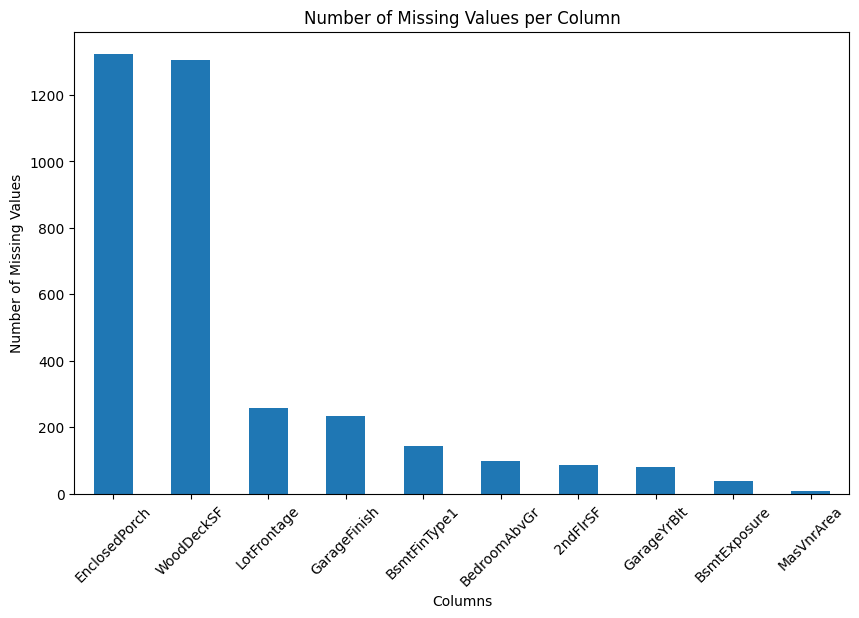

In [3]:
# Summary of missing values sorted in descending order
missing_data_summary = df.isnull().sum().sort_values(ascending=False)
missing_data_summary = missing_data_summary[missing_data_summary > 0]  # Include only columns with missing values

# Bar plot showing the number of missing values per column
plt.figure(figsize=(10, 6))
missing_data_summary.plot(kind='bar')
plt.title('Number of Missing Values per Column')
plt.ylabel('Number of Missing Values')
plt.xlabel('Columns')
plt.xticks(rotation=45)
plt.show()


##### As the chart shows, **EnclosedPorch** and **WoodDeckSF** are missing 90% and 89% of their values, respectively. For this reason, they will be removed using "DropFeatures".

___

##### This code checks if any rows in the **SalePrice** column have zero or negative values. These are not realistic for house prices. It helps to make sure the data is correct before analysis. If such rows exist, they are shown for review.

In [4]:
# Identify rows with negative or zero SalePrice values
negative_values = df[df['SalePrice'] < 0]  # Filter rows where SalePrice is negative
zero_values = df[df['SalePrice'] == 0]  # Filter rows where SalePrice is zero

# Print the count of negative and zero SalePrice rows
print(f"Number of rows with negative SalePrice: {len(negative_values)}")
print(f"Number of rows with SalePrice = 0: {len(zero_values)}")

# If any rows with negative SalePrice exist, display the first few rows
if not negative_values.empty:
    print("Rows with negative SalePrice:")
    print(negative_values.head())

# If any rows with SalePrice = 0 exist, display the first few rows
if not zero_values.empty:
    print("Rows with SalePrice = 0:")
    print(zero_values.head())


Number of rows with negative SalePrice: 0
Number of rows with SalePrice = 0: 0


##### No rows in the **SalePrice** column have zero or negative values. This confirms that the data is valid and ready for further analysis.

##### The next step is cleaning the dataset using a pipeline.

___

##### Features with many missing values are removed using **DropFeatures** (**EnclosedPorch** and **WoodDeckSF**).

##### Categorical features with fewer missing values are filled with the most frequent category using **CategoricalImputer** to keep the data consistent (**GarageFinish**, **BsmtFinType1**, and **BsmtExposure**).

##### Missing values in numerical columns like **LotFrontage**, **BedroomAbvGr**, and **GarageYrBlt** are filled with the median using **MeanMedianImputer**, as it is less affected by outliers.

##### For specific numerical columns like **2ndFlrSF** and **MasVnrArea**, missing values are replaced with zero using **ArbitraryNumberImputer** because their absence usually has a specific meaning (no second floor).

##### The **SalePrice** column is excluded from all transformations to keep its values unchanged for analysis.

##### The pipeline is applied step by step to clean and transform the dataset (df_cleaned) systematically.

##### After cleaning, the dataset is checked to confirm no rows have negative or zero **SalePrice**, as these would not be valid for analysis.

In [5]:
# List of features to drop
dropped_features = ['EnclosedPorch', 'WoodDeckSF']

# List of categorical features
categorical_features = ['GarageFinish', 'BsmtFinType1', 'BsmtExposure']
median_features = ['LotFrontage', 'BedroomAbvGr', 'GarageYrBlt']
features_to_impute_with_zero = ['2ndFlrSF', 'MasVnrArea']

# Ensure that SalePrice is not included in the transformation steps
numerical_features = df.select_dtypes(include=['number']).columns.tolist()
numerical_features.remove('SalePrice')  # Exclude SalePrice

# Create pipeline to clean data
pipeline = Pipeline([
    # Drop irrelevant or highly missing features
    ('DropFeatures', DropFeatures(features_to_drop=dropped_features)),
    ('CategoricalImputer', CategoricalImputer(imputation_method='frequent', variables=categorical_features)),
    ('MeanMedianImputer', MeanMedianImputer(imputation_method='median', variables=median_features)),
    ('ArbitraryNumberImputer', ArbitraryNumberImputer(arbitrary_number=0, variables=features_to_impute_with_zero)),
])

# Apply pipeline to dataframe
df_cleaned = pipeline.fit_transform(df)

# Check for negative or zero values in SalePrice
negative_values = df_cleaned[df_cleaned['SalePrice'] < 0]
zero_values = df_cleaned[df_cleaned['SalePrice'] == 0]

# Print to confirm cleaning process
print(f"Pipeline applied successfully!")
print(f"Number of rows with negative SalePrice: {len(negative_values)}")
print(f"Number of rows with SalePrice = 0: {len(zero_values)}")
print(f"Dataset shape after cleaning: {df_cleaned.shape}")

Pipeline applied successfully!
Number of rows with negative SalePrice: 0
Number of rows with SalePrice = 0: 0
Dataset shape after cleaning: (1460, 22)


**Result:**

The pipeline ran successfully:

No rows have negative or zero SalePrice, ensuring valid data for analysis.
The dataset now has 1460 rows and 22 columns, with irrelevant or missing features removed.
The data is clean and ready for the next steps.


Next, duplicates will be removed. 

___

##### **Remove duplicates**

##### Remove duplicates to keep data clean and avoid repeated information that could harm model accuracy.

In [56]:
df_cleaned.drop_duplicates(inplace=True)
print(f"Duplicates after cleaning: {df_cleaned.duplicated().sum()}")
print(f"Shape of data after removing duplicates: {df_cleaned.shape}")

Duplicates after cleaning: 0
Shape of data after removing duplicates: (1460, 22)


No duplicates were found in the dataset. The shape remains unchanged at 1460 rows and 22 columns, ensuring the data is clean and ready for analysis.

Next, outliers will be analyzed.

___

##### Key features like **LotArea**, **GrLivArea**, and **SalePrice** are analyzed for extreme values using the 2nd and 98th percentiles. This helps understand the data distribution and ensures outliers won’t affect the model. The shape of the dataset stays the same as no rows are removed.

In [57]:
# Log information about outliers without removing them
important_features = ['LotArea', 'GrLivArea', 'SalePrice']

# Percentile thresholds
lower_percentile = 0.02
upper_percentile = 0.98

# Check for outliers
for feature in important_features:
    lower_limit = df_cleaned[feature].quantile(lower_percentile)
    upper_limit = df_cleaned[feature].quantile(upper_percentile)
    
    # Log the number of outliers
    outliers = df_cleaned[(df_cleaned[feature] < lower_limit) | (df_cleaned[feature] > upper_limit)]
    print(f"Feature: {feature}, Outliers detected: {len(outliers)}")

# Log data shape after identifying outliers
print(f"Data shape after logging outliers (no rows removed): {df_cleaned.shape}")

Feature: LotArea, Outliers detected: 60
Feature: GrLivArea, Outliers detected: 59
Feature: SalePrice, Outliers detected: 59
Data shape after logging outliers (no rows removed): (1460, 22)


**Outlier detection results:**

**LotArea**: 60 outliers detected.

**GrLivArea:** 59 outliers detected.

**SalePrice:** 59 outliers detected.

The dataset shape remains unchanged at 1460 rows and 22 columns, as outliers were only logged and not removed. This ensures all data is preserved for analysis, while identifying potential extreme values for further consideration.

___

##### Check data types to make sure all columns have the correct data types after transformations.

In [58]:
df_cleaned.dtypes

1stFlrSF         float64
2ndFlrSF         float64
BedroomAbvGr     float64
BsmtExposure    category
BsmtFinSF1       float64
BsmtFinType1    category
BsmtUnfSF        float64
GarageArea       float64
GarageFinish    category
GarageYrBlt      float64
GrLivArea        float64
KitchenQual     category
LotArea          float64
LotFrontage      float64
MasVnrArea       float64
OpenPorchSF      float64
OverallCond        int64
OverallQual        int64
TotalBsmtSF      float64
YearBuilt          int64
YearRemodAdd       int64
SalePrice        float64
dtype: object

**The data types in df_cleaned were checked:**

Numerical features like **1stFlrSF**, **GarageArea**, **SalePrice** are correctly stored as float64 or int64. This makes them ready for calculations and modeling.
Categorical features like **BsmtExposure**, **GarageFinish** are stored as category, saving memory and making them easy to process.
The data types confirm that the cleaning steps worked, and the dataset is ready to save and use in the next steps.

___

## Push files to repo

In [6]:
df_cleaned.to_csv("outputs/datasets/collection/HousePricesCleaned.csv", index=False)
print("Exported the transformed dataset successfully!")

Exported the transformed dataset successfully!


In [7]:
print("Data Cleaning Summary:")
print(f"Initial shape: {df.shape}")
print(f"Shape after cleaning: {df_cleaned.shape}")

Data Cleaning Summary:
Initial shape: (1460, 24)
Shape after cleaning: (1460, 22)


##### **Data Cleaning Summary**
**Missing Values:** Filled missing numbers with the median and missing categories with the most common value. Removed columns with too many missing values.

**Outliers:** Logged outliers in LotArea, GrLivArea, and SalePrice without removing them.

**Visualization:** Used bar plots to show missing data for each column.

**Pipeline:** Used a pipeline to drop columns, fill missing values, and clean the data.

**Data Types:** Verified the data types for all columns to ensure consistency and readiness for modeling.

**Export:** Saved the cleaned data **HousePricesCleaned.csv** for further analysis.